In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import os

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load dataset

In [2]:
pwd = os.getcwd()
train_df = pd.read_csv((pwd + '/Data/train.csv'))
test = pd.read_csv((pwd + '/Data/test.csv'))
combine = [train_df, test]

In [ ]:
train_df

In [ ]:
test

In [ ]:
combine

## Descriptive stat of the data

##### Which features are available in the dataset?

In [6]:
train_df.columns
# Categorical: Survived, Sex, and Embarked. Ordinal: Pclass
# Continous: Age, Fare
# Discrete: SibSp, Parch

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

* Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric
* Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names

##### Which features contain blank, null or empty values?

In [7]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

* Cabin > Age > Embarked features contain a number of null values in that order for the training dataset

##### What are the data types for various features?

In [8]:
train_df.info()
print('-'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

##### What is the distribution of numerical feature values across the data?

In [9]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
* Survived is a categorical feature with 0 or 1 values.
* Around 38% samples survived representative of the actual survival rate at 32%.
* Most passengers (> 75%) did not travel with parents or children.
* Nearly 30% of the passengers had siblings and/or spouse aboard.
* Fares varied significantly with few passengers (<1%) paying as high as $512.
* Few elderly passengers (<1%) within age range 65-80, more than 75% of passengers below age of 40

##### What is the distribution of categorical features?

In [10]:
# describe the string/object column
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",male,CA. 2343,G6,S
freq,1,577,7,4,644


In [11]:
train_df['Cabin'].value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
F33            3
C22 C26        3
              ..
E38            1
C104           1
D45            1
D49            1
C118           1
Name: Cabin, Length: 147, dtype: int64

* Names are unique across the dataset (count=unique=891)
* Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
* Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
* Embarked takes three possible values. S port used by most passengers (top=S)
* Ticket feature has high ratio (22%) of duplicate values (unique=681).

## Analyze by pivoting features
- We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type

* Pclass We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.

In [12]:
train_df[['Survived', 'Pclass']].groupby('Pclass', as_index=False).mean().sort_values(by = 'Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


* Sex We confirm the observation during problem definition that Sex=female had very high survival rate at 74%

In [13]:
train_df[['Survived', 'Sex']].groupby('Sex', as_index=False).mean().sort_values(by = 'Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


* SibSp and Parch These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (creating #1).

In [14]:
train_df[['Survived', 'SibSp']].groupby('SibSp', as_index=False).mean().sort_values(by = 'Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [15]:
train_df[['Survived', 'Parch']].groupby('Parch', as_index=False).mean().sort_values(by = 'Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## Analyze by visualizing data

##### Correlation between Survival and Age numerical features (Age)

<AxesSubplot:xlabel='Age', ylabel='Count'>

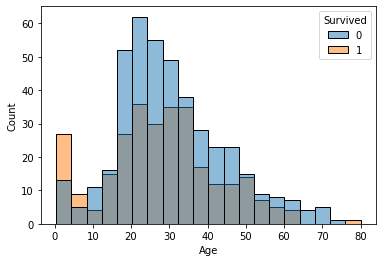

In [16]:
train_age_df = train_df[['Survived', 'Age']]
sns.histplot(x = 'Age', hue = 'Survived', data = train_age_df)

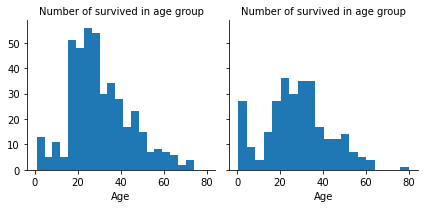

In [17]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)
g.set_titles('Number of survived in age group');


* Infants (Age <=4) had high survival rate.
* Oldest passengers (Age = 80) survived.
* Large number of 15-25 year olds did not survive.
* Most passengers are in 15-35 age range.

##### Correlation bewteen Survival and Pclass

* Mean of survival for each Pclass

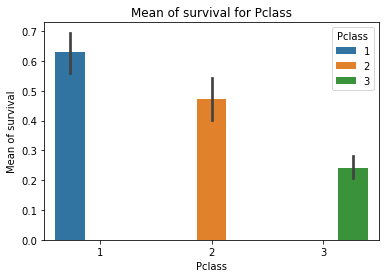

In [18]:
# mean of survival for each Pclass
g = sns.barplot(x = train_df['Pclass'], y = train_df['Survived'], hue = 'Pclass',data = train_df)
g.set_title('Mean of survival for Pclass')
g.set_ylabel('Mean of survival');

* Sum of survival for each Pclass

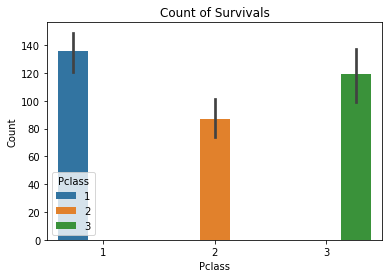

In [19]:
# sum of survival for each Pclass
g = sns.barplot(x = train_df['Pclass'], y = train_df['Survived'], hue = 'Pclass',data = train_df, estimator=sum)
g.set_title('Count of Survivals')
g.set_ylabel('Count');

* Proportion of ppl survived in each pclass

<ipython-input-20-a0931362913f>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['0','1','','','','2','', '', '','3']);


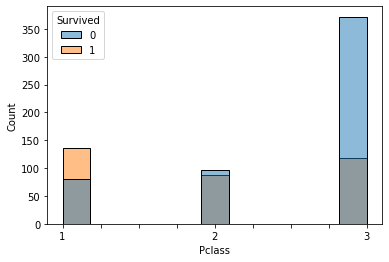

In [20]:
train_pclass_df = train_df[['Survived', 'Pclass']]
g = sns.histplot(x = 'Pclass', hue = 'Survived', data = train_pclass_df)
g.set_xticklabels(['0','1','','','','2','', '', '','3']);

* proportion of ppl survived in each Pclass and Age

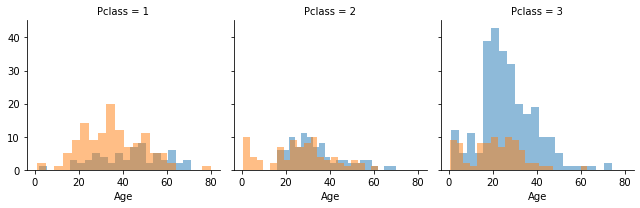

In [21]:
g = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
g.map(plt.hist, 'Age', alpha=.5, bins=20);

* Overview of Survived (Pclass and Age)

/Users/joelai/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


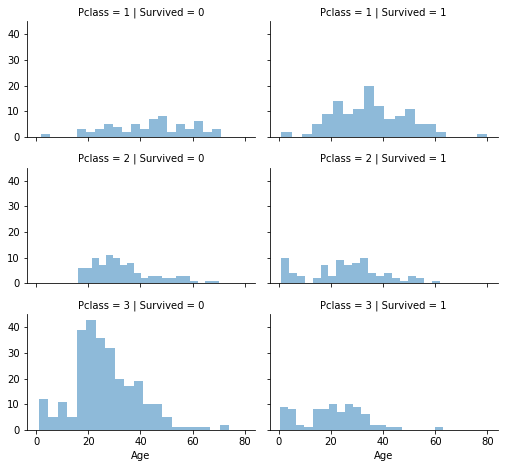

In [22]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

* Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
* Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
* Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
* Pclass varies in terms of Age distribution of passengers.

##### Correlation bewteen Survival and Embarked

/Users/joelai/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


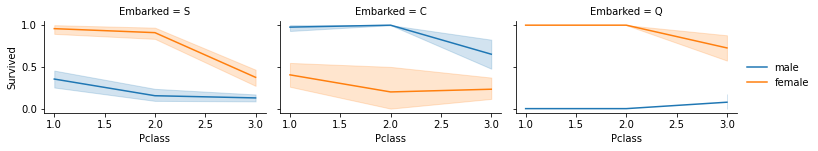

In [23]:
grid = sns.FacetGrid(train_df, col = 'Embarked', size = 2.2, aspect = 1.6)
grid.map(sns.lineplot, 'Pclass', 'Survived', 'Sex' )
grid.add_legend();

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

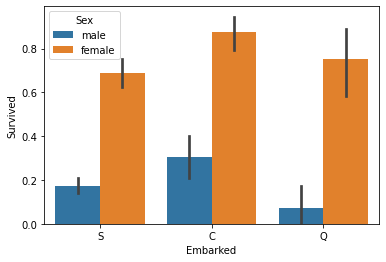

In [24]:
sns.barplot(data = train_df, x = 'Embarked', y = 'Survived', hue = 'Sex')

* Female passengers had much better survival rate than males
* Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived
* Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports
* Ports of embarkation have varying survival rates for Pclass=3 and among male passengers

##### Correlation (Embarked, Sex, Fare, Survived)

/Users/joelai/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/joelai/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


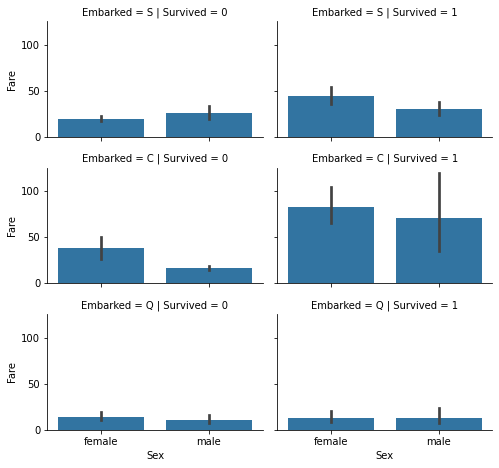

In [25]:
g = sns.FacetGrid(train_df, row = 'Embarked', col = 'Survived', size = 2.2, aspect = 1.6)
g.map(sns.barplot, 'Sex','Fare');

* Higher fare paying passengers had better survival
* Port of embarkation correlates with survival rates

# Wrangle data
* we want to drop the Cabin and Ticket as they contain many null values

##### Correcting by dropping features

In [26]:
print('Before')
print('Train_Columns:', train_df.columns.values)
print('Length:', len(train_df.columns.values))
print('Test_Columns:', test.columns.values)
print('Length:', len(test.columns.values))

train_df = train_df.drop(columns=['Ticket', 'Cabin'])
test = test.drop(columns=['Ticket', 'Cabin'])
combine = [train_df, test]
print('-'*50)

print('After')
print('Train_Columns:', train_df.columns.values)
print('Length:', len(train_df.columns.values))
print('Test_Columns:', test.columns.values)
print('Length:', len(test.columns.values))


Before
Train_Columns: ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
Length: 12
Test_Columns: ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']
Length: 11
--------------------------------------------------
After
Train_Columns: ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Fare' 'Embarked']
Length: 10
Test_Columns: ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare'
 'Embarked']
Length: 9


##### Creating new feature extracting from existing
* Name feature can be engineered to extract titles and test correlation between titles and survival, before dropping Name and PassengerId features

* Create title column to train_df and test

In [27]:
def get_titles(column):
    return column.split(',')[1].split('.')[0].strip()

for dataset in combine:
    dataset['Title'] = dataset['Name'].apply(lambda x: get_titles(x))

# Count Title and Sex
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40
Miss,182,0


In [28]:
# update the combine dataset
combine = [train_df, test]

* Replace many titles with a more common name or classify them as Rare

In [ ]:
# see the values in Title
train_df['Title'].value_counts()

In [30]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
# the mean survival rate among different titles
train_df[['Title', 'Survived']].groupby('Title', as_index= False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


* Certain titles mostly survived (Female and Master)

##### Convert Titles to ordinal for further analysis

In [31]:
# a dict for mapping
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

# convert train_df
train_df['Title'] = train_df['Title'].map(title_mapping)
train_df['Title'] = train_df['Title'].fillna(0)

# convert test
test['Title'] = train_df['Title'].map(title_mapping)
test['Title'] = train_df['Title'].fillna(0)

train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S,5
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,S,2
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C,1


##### After extracting useful info from Name, we can now drop the Name and PassengerId columns

In [32]:
train_df = train_df.drop(columns=['Name', 'PassengerId'])
test = test.drop(['Name'], axis =1)
combine = [train_df, test]
print(train_df.shape, test.shape)

(891, 9) (418, 9)


##### Converting a categorical feature
Convert features which contain strings to numerical values. This is required by most model algorithms. Doing so will also help us in achieving the feature completing goal

In [33]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)

train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1
...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,S,5
887,1,1,1,19.0,0,0,30.0000,S,2
888,0,3,1,NaN,1,2,23.4500,S,2
889,1,1,0,26.0,0,0,30.0000,C,1


##### Completing a numerical continuous feature
Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.

1. Generate random numbers between mean and standard deviation.
2. Filling missing values by using other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using median values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...
3. Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.

Method 1 and 3 may introduce randomness making our model inaccurate. The results from multiple executions might vary. We will prefer method 2

* look at the distribution of age among different of Sex and Pcalss > 6 combinsations

/Users/joelai/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


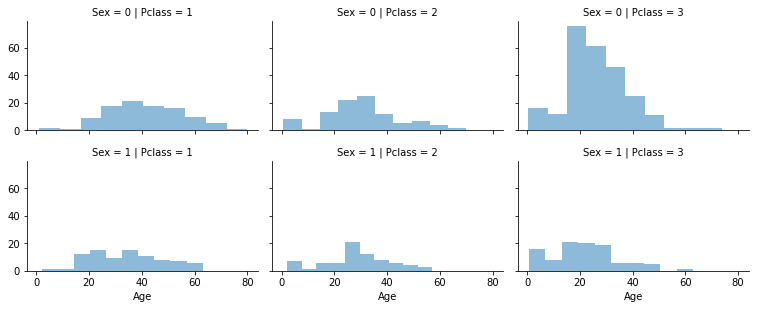

In [34]:
g = sns.FacetGrid(train_df, col = 'Pclass', row = 'Sex', size=2.2, aspect=1.6)
g.map(plt.hist, 'Age', alpha = .5)
g.add_legend();

* Prepare an empty array to contain guessed Age values based on Pclass x Gender combinations

In [35]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

* Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations

In [36]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int(age_guess/0.5 + 0.5 ) * 0.5
    
    # Paste age from guess_ages to the original dataset
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset['Age'].isnull()) & (dataset['Sex'] == i) & (dataset['Pclass'] == j+1),'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1
...,...,...,...,...,...,...,...,...,...
886,0,2,0,27,0,0,13.0000,S,5
887,1,1,1,19,0,0,30.0000,S,2
888,0,3,1,21,1,2,23.4500,S,2
889,1,1,0,26,0,0,30.0000,C,1


In [37]:
# guess_df = dataset[(dataset['Sex'] == 0) & dataset['Pclass'] == 0+1]['Age'].dropna()

# age_guess = guess_df.median()
# age_guess

In [38]:
# train_df.loc[(train_df['Age'].isnull()) & (train_df['Sex'] == 0) & (train_df['Pclass'] == 0+1), 'Age']

* Create Age bands and determine correlations with Survived

In [39]:
train_df['Age'].describe()

count    891.000000
mean      29.072952
std       13.326339
min        0.000000
25%       21.000000
50%       26.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

In [40]:
bins = np.arange(0, 81, 16)
train_df['AgeBand'] = pd.cut(train_df['Age'], bins)
train_df[['AgeBand', 'Survived']].groupby('AgeBand', as_index=False).mean().sort_values(by = 'AgeBand', ascending=True)

,AgeBand,Survived
0,"(0, 16]",0.516129
1,"(16, 32]",0.337374
2,"(32, 48]",0.412037
3,"(48, 64]",0.434783
4,"(64, 80]",0.090909


* Let us replace Age with ordinals based on these bands.

In [41]:
for dataset in combine:
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

train_df['Age'].value_counts()

1    495
2    216
0    100
3     69
4     11
Name: Age, dtype: int64

* We can not remove the AgeBand feature

In [42]:
train_df = train_df.drop(columns='AgeBand')
combine = [train_df, test]
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1
...,...,...,...,...,...,...,...,...,...
886,0,2,0,1,0,0,13.0000,S,5
887,1,1,1,1,0,0,30.0000,S,2
888,0,3,1,1,1,2,23.4500,S,2
889,1,1,0,1,0,0,30.0000,C,1


##### Create new feature combining existing features (FamilySize)
We can create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets

In [43]:
for dataset in combine:
    dataset['FamilySize'] = dataset['Parch'] + dataset['SibSp'] + 1
train_df[['FamilySize', 'Survived']].groupby('FamilySize').mean().sort_values(by = 'FamilySize')

,Survived
FamilySize,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


* Create another feature called IsAlone

In [44]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1 # .loc is to get rows from original dataset
    dataset[dataset['FamilySize'] == 1]['IsAlone'] = 1 # this is to create a new dataframe

train_df[['IsAlone', 'Survived']].groupby('IsAlone', as_index=False).mean().sort_values(by='IsAlone')

<ipython-input-44-d140ccbb5971>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[dataset['FamilySize'] == 1]['IsAlone'] = 1 # this is to create a new dataframe
<ipython-input-44-d140ccbb5971>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[dataset['FamilySize'] == 1]['IsAlone'] = 1 # this is to create a new dataframe


,IsAlone,Survived
0,0,0.505650
1,1,0.303538


* Drop Parch, SibSp, and FamilySize features in favor of IsAlone.

In [45]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test = test.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test]

train_df

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1
...,...,...,...,...,...,...,...,...
886,0,2,0,1,13.0000,S,5,1
887,1,1,1,1,30.0000,S,2,1
888,0,3,1,1,23.4500,S,2,0
889,1,1,0,1,30.0000,C,1,1


* Create an artificial feature combining Pclass and Age

In [46]:
for dataset in combine:
    dataset['Age*Class'] = dataset['Age'] * dataset['Pclass']

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']]

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
...,...,...,...
886,2,1,2
887,1,1,1
888,3,1,3
889,1,1,1


##### Completing and converting a categorical feature (Embarked)
Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [47]:
freq_port = train_df['Embarked'].dropna().mode()[0]
freq_port

'S'

In [48]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

train_df[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean().sort_values(by = 'Embarked')

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [49]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

train_df

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6
...,...,...,...,...,...,...,...,...,...
886,0,2,0,1,13.0000,0,5,1,2
887,1,1,1,1,30.0000,0,2,1,1
888,0,3,1,1,23.4500,0,2,0,3
889,1,1,0,1,30.0000,1,1,1,1


##### Completing and converting a numeric feature (Fare)

In [50]:
Fare_median = test['Fare'].dropna().median()
test['Fare'].fillna(Fare_median, inplace=True)
test

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,2,1,6
3,895,3,0,1,8.6625,0,3,1,3
4,896,3,1,1,12.2875,0,1,0,3
...,...,...,...,...,...,...,...,...,...
413,1305,3,0,1,8.0500,0,1,1,3
414,1306,1,1,2,108.9000,1,1,1,2
415,1307,3,0,2,7.2500,0,3,1,6
416,1308,3,0,1,8.0500,0,3,1,3


* We can create FareBand

In [51]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df['FareBand'].value_counts()

(7.91, 14.454]     224
(-0.001, 7.91]     223
(14.454, 31.0]     222
(31.0, 512.329]    222
Name: FareBand, dtype: int64

In [52]:
train_df[['FareBand', 'Survived']].groupby('FareBand', as_index=False).mean().sort_values(by = 'FareBand')

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


* Convert the Fare feature to ordinal values based on the FareBand

In [53]:
for dataset in combine:
    dataset.loc[(dataset['Fare'] <= 7.91), 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 31), 'Fare'] = 3
    dataset['Fare'].astype(int)

train_df

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class,FareBand
0,0,3,0,1,0.0,0,1,0,3,"(-0.001, 7.91]"
1,1,1,1,2,3.0,1,3,0,2,"(31.0, 512.329]"
2,1,3,1,1,1.0,0,2,1,3,"(7.91, 14.454]"
3,1,1,1,2,3.0,0,3,0,2,"(31.0, 512.329]"
4,0,3,0,2,1.0,0,1,1,6,"(7.91, 14.454]"
...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,1,1.0,0,5,1,2,"(7.91, 14.454]"
887,1,1,1,1,2.0,0,2,1,1,"(14.454, 31.0]"
888,0,3,1,1,2.0,0,2,0,3,"(14.454, 31.0]"
889,1,1,0,1,2.0,1,1,1,1,"(14.454, 31.0]"


In [54]:
train_df = train_df.drop(columns='FareBand')
combine = [train_df, test]
train_df

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0.0,0,1,0,3
1,1,1,1,2,3.0,1,3,0,2
2,1,3,1,1,1.0,0,2,1,3
3,1,1,1,2,3.0,0,3,0,2
4,0,3,0,2,1.0,0,1,1,6
...,...,...,...,...,...,...,...,...,...
886,0,2,0,1,1.0,0,5,1,2
887,1,1,1,1,2.0,0,2,1,1
888,0,3,1,1,2.0,0,2,0,3
889,1,1,0,1,2.0,1,1,1,1


In [55]:
test

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0.0,2,1,1,6
1,893,3,1,2,0.0,0,3,0,6
2,894,2,0,3,1.0,2,2,1,6
3,895,3,0,1,1.0,0,3,1,3
4,896,3,1,1,1.0,0,1,0,3
...,...,...,...,...,...,...,...,...,...
413,1305,3,0,1,1.0,0,1,1,3
414,1306,1,1,2,3.0,1,1,1,2
415,1307,3,0,2,0.0,0,3,1,6
416,1308,3,0,1,1.0,0,3,1,3


# Model, predict and solve

* Logistic Regression
* KNN or k-Nearest Neighbors
* Support Vector Machines
* Naive Bayes classifier
* Decision Tree
* Random Forrest
* Perceptron
* Artificial neural network
* RVM or Relevance Vector Machine


In [56]:
# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

##### Logistic Regression
* split the columns of dependent vaiable (Survived) and independent variables (Features)

In [57]:
x_train = train_df.drop(columns='Survived')
y_train = train_df['Survived']
x_test  = test.drop(columns="PassengerId").copy()

In [ ]:
x_train

In [ ]:
y_train

* Confidence score generated by the model based on our training dataset

In [60]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

# return the mean accuracy of the data and labels
acc_log = round(logreg.score(x_train, y_train) * 100, 2)
acc_log

81.37

* Coefficient of the features in the decision function

In [61]:
# Dataframe wihtout Survival column
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']

# Create an array of coefficent
coeff_df["Coefficent"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Coefficent', ascending=False)

,Feature,Coefficent
1,Sex,2.201057
5,Title,0.406027
4,Embarked,0.276628
6,IsAlone,0.185986
7,Age*Class,-0.050260
3,Fare,-0.071665
2,Age,-0.469638
0,Pclass,-1.200309


* Sex is highest positivie coefficient, implying as the Sex value increases (male: 0 to female: 1), the probability of Survived=1 increases the most.
* Inversely as Pclass increases, probability of Survived=1 decreases the most.
* This way Age*Class is a good artificial feature to model as it has second highest negative correlation with Survived.
* So is Title as second highest positive correlation.

##### Support Vector Machines

In [ ]:
svc = SVC()
svc.fit(x_train, y_train)
x_pred = svc.predict(x_test)
acc_svc = round(svc.score(x_train, y_train) * 100, 2)
acc_svc

##### k-Nearest Neighbors algorithm

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
Y_pred = knn.predict(x_test)
acc_knn = round(knn.score(x_train, y_train) * 100, 2)
acc_knn

##### Gaussian Naive Bayes

In [ ]:
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
Y_pred = gaussian.predict(x_test)
acc_gaussian = round(gaussian.score(x_train, y_train) * 100, 2)
acc_gaussian

##### Perceptron

In [ ]:
perceptron = Perceptron()
perceptron.fit(x_train, y_train)
Y_pred = perceptron.predict(x_test)
acc_perceptron = round(perceptron.score(x_train, y_train) * 100, 2)
acc_perceptron

##### Linear SVC

In [ ]:
linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
Y_pred = linear_svc.predict(x_test)
acc_linear_svc = round(linear_svc.score(x_train, y_train) * 100, 2)
acc_linear_svc

##### Stochastic Gradient Descent

In [ ]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
Y_pred = sgd.predict(x_test)
acc_sgd = round(sgd.score(x_train, y_train) * 100, 2)
acc_sgd

##### Decision Tree

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
Y_pred = decision_tree.predict(x_test)
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

## Model Evaluation
* We can now rank our evaluation of all the models to choose the best one for our problem

In [69]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
7,Decision Tree,86.64
1,KNN,84.06
0,Support Vector Machines,82.83
2,Logistic Regression,81.37
6,Linear SVC,79.46
4,Perceptron,79.35
3,Naive Bayes,76.88
5,Stochastic Gradient Decent,70.71


## Model Prediction with Decision Tree

* With the highest confidence score of 86.64, we will choose Decision Tree as a predicting model to our 'test' dataset

In [70]:
# using T_predict from Decision tree to predict the survival
prediction = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        'Pclass': test['Pclass'],
        'Sex': test['Sex'],
        'Age': test['Age'],
        'Fare': test['Fare'],
        'Title': test['Title'],
        'IsAlone': test['IsAlone'],
        "Survived": Y_pred})
prediction

,PassengerId,Pclass,Sex,Age,Fare,Title,IsAlone,Survived
0,892,3,0,2,0.0,1,1,0
1,893,3,1,2,0.0,3,0,0
2,894,2,0,3,1.0,2,1,0
3,895,3,0,1,1.0,3,1,0
4,896,3,1,1,1.0,1,0,0
...,...,...,...,...,...,...,...,...
413,1305,3,0,1,1.0,1,1,0
414,1306,1,1,2,3.0,1,1,0
415,1307,3,0,2,0.0,3,1,0
416,1308,3,0,1,1.0,3,1,0


##### Survival rate of different Pclass

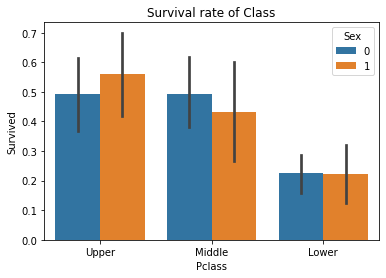

In [71]:
g = sns.barplot(y = 'Survived', x = 'Pclass', data = prediction, hue = 'Sex')
g.set_title('Survival rate of Class')
g.set_xticklabels(['Upper','Middle','Lower']);

##### Survival rate of different Age Groups

In [72]:
prediction_age = prediction.groupby(['Age', 'Sex']).mean().sort_values('Age')[['Survived']]
prediction_age

Survived
Age Sex          
0   0    0.210526
    1    0.066667
1   0    0.325444
    1    0.363636
2   0    0.454545
    1    0.575758
3   0    0.363636
    1    0.333333
4   0    0.000000
    1    0.000000

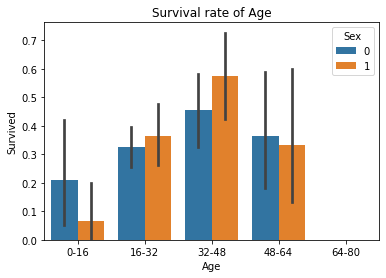

In [73]:
g = sns.barplot(y = 'Survived', x = 'Age', data = prediction, hue = 'Sex')
g.set_title('Survival rate of Age')
g.set_xticklabels(['0-16','16-32','32-48', '48-64', '64-80']);

##### Survival rate of different Title

In [74]:
prediction['Title'].value_counts()

1    228
2    101
3     59
4     23
5      7
Name: Title, dtype: int64

* the Title of '5' is non-esstential as it has only 7 counts, which may lead to outlier >>> drop those rows

In [75]:
predictoin_title = prediction.loc[prediction['Title'] != 5]
predictoin_title

,PassengerId,Pclass,Sex,Age,Fare,Title,IsAlone,Survived
0,892,3,0,2,0.0,1,1,0
1,893,3,1,2,0.0,3,0,0
2,894,2,0,3,1.0,2,1,0
3,895,3,0,1,1.0,3,1,0
4,896,3,1,1,1.0,1,0,0
...,...,...,...,...,...,...,...,...
413,1305,3,0,1,1.0,1,1,0
414,1306,1,1,2,3.0,1,1,0
415,1307,3,0,2,0.0,3,1,0
416,1308,3,0,1,1.0,3,1,0


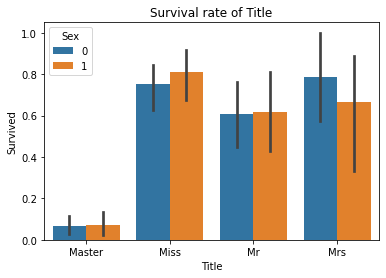

In [76]:
g = sns.barplot(y = 'Survived', x = 'Title', data = predictoin_title, hue = 'Sex')
g.set_title('Survival rate of Title')
g.set_xticklabels(['Master','Miss','Mr', 'Mrs']);

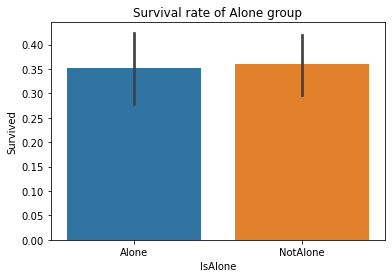

In [77]:
g = sns.barplot(y = 'Survived', x = 'IsAlone', data = prediction)
g.set_title('Survival rate of Alone group')
g.set_xticklabels(['Alone','NotAlone']);

### Summary of prediction from testing dataset
1. Pclass: higher classes imply a higher survival rate
2. Age: 32-48 age group has the highest survival rate
3. Female has a higher survival rate of male
4. Passenagers who are not alone have a slightly higher survival rate